In [1]:
# Download data from Google Drive link
# https://drive.google.com/file/d/1hHH_gIt_BDo9xjyAmDOFXc4fk_wnVhx7/view?usp=sharing

!wget 'https://docs.google.com/uc?export=download&id=1hHH_gIt_BDo9xjyAmDOFXc4fk_wnVhx7&confirm=t' 
!mv 'uc?export=download&id=1hHH_gIt_BDo9xjyAmDOFXc4fk_wnVhx7&confirm=t' data_1770.zip
!unzip 'data_1770.zip' -d ""
# %cd data_1770

--2023-04-23 15:00:32--  https://docs.google.com/uc?export=download&id=1hHH_gIt_BDo9xjyAmDOFXc4fk_wnVhx7&confirm=t
Resolving docs.google.com (docs.google.com)... 172.253.62.102, 172.253.62.113, 172.253.62.139, ...
Connecting to docs.google.com (docs.google.com)|172.253.62.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/63m7o8sb8fkkbhbdjhana8cr5f4jiq49/1682262000000/07581882750022606773/*/1hHH_gIt_BDo9xjyAmDOFXc4fk_wnVhx7?e=download&uuid=c1f1d923-00ca-4989-8a7a-cdfcb87d096d [following]
--2023-04-23 15:00:32--  https://doc-14-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/63m7o8sb8fkkbhbdjhana8cr5f4jiq49/1682262000000/07581882750022606773/*/1hHH_gIt_BDo9xjyAmDOFXc4fk_wnVhx7?e=download&uuid=c1f1d923-00ca-4989-8a7a-cdfcb87d096d
Resolving doc-14-40-docs.googleusercontent.com (doc-14-40-docs.googleusercontent.com)... 172.253.62.132, 

In [2]:
import numpy as np
import os
from PIL import Image
import cv2

all_imgs = [] #train images
all_labels = [] #labels for each image: 0 is snowberg, 1 is cloud


# read images
for label in ['cloud','snowberg']: # read images from each folder
  for img in os.listdir(label): # each image
    if label == 'cloud': # if image is in cloud folder, add cloud label
      all_labels.append(1)
    else: #snowberg
      all_labels.append(0)
    temp = np.array(Image.open(label+'/'+img))
    temp =  cv2.resize(temp, dsize=(64,64)) # original data size is 256*256 but for faster training, resize to 64*64
    all_imgs.append(temp)
    # print(temp.shape)
all_imgs = np.array(all_imgs)
all_labels = np.array(all_labels)
print(all_imgs.shape) # 3540 images with size 64x64 and 3 color channels

(3540, 64, 64, 3)


In [3]:
# all_imgs[0]

In [4]:
# split to train, test, validation set with each set with 50% snow and 50% cloud images
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_imgs, all_labels, test_size=0.2, stratify=all_labels, random_state=0) 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(2832, 64, 64, 3)
(2832,)
(354, 64, 64, 3)
(354,)
(354, 64, 64, 3)
(354,)


In [5]:
# X_train[0]

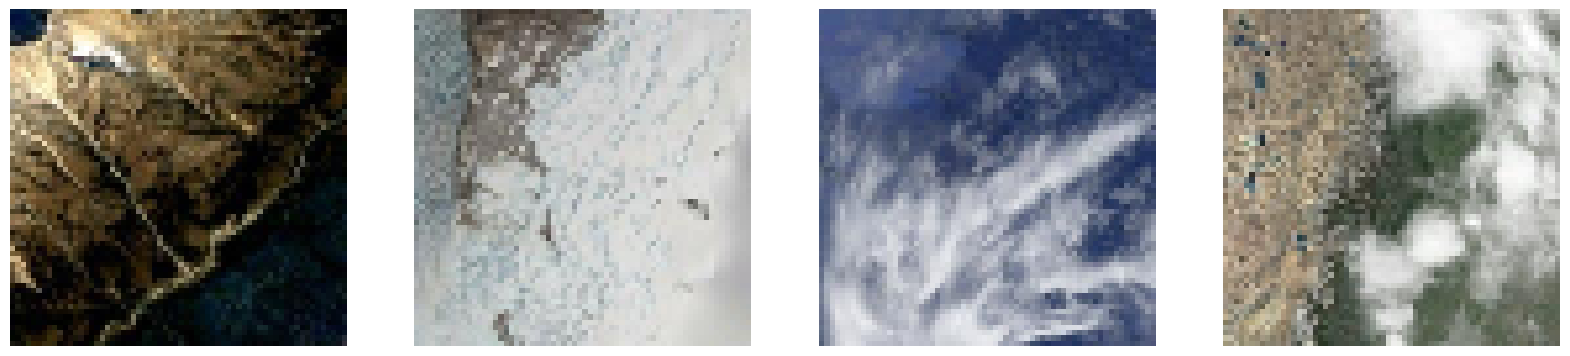

labels:  [0 0 1 1]


In [6]:
# plot example images in the train set and their labels

import matplotlib.pyplot as plt
# plt.imshow(all_imgs[0]) #displays (pixel) data as an image

fig,ax = plt.subplots(1,4,figsize=(20,10))
for i in np.arange(0,4,1):
    # ax[i].imshow(X_train[i].reshape(64,64,3))
    ax[i].imshow(X_train[i])
    ax[i].axis('off')
plt.show()
print("labels: ",y_train[:4])

In [7]:
# normalise data by dividing by 255
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [8]:
# X_train[0]

In [9]:
# import torch
import torchvision

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Create Models

In [11]:
# data loader in PyTorch change input shape so CNN model can take in
train_dataset = TensorDataset( Tensor(X_train).permute(0, 3, 1, 2), Tensor(y_train).long() )
val_dataset = TensorDataset( Tensor(X_val).permute(0, 3, 1, 2), Tensor(y_val).long() )
test_dataset = TensorDataset( Tensor(X_test).permute(0, 3, 1, 2), Tensor(y_test).long() )
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=40,shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=40,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=40,shuffle=False)

In [12]:
# First model with two convolutional layers
class twoLayers(nn.Module):
    def __init__(self):
        super(twoLayers, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5)# (in channels, out channels, kernel size (9x9))
        self.pool = nn.MaxPool2d(2, 2) #(kernel size (2x2), stride (2x2))
        self.conv2 = nn.Conv2d(5,10,5) #(in channels from first layer, out channels, kernel size (5x5))
        self.fc1 = nn.Linear(10*13*13, 200) #
        self.fc2 = nn.Linear(200, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x): # x is the batch of input data to nn
        x = self.pool(F.relu(self.conv1(x))) # CONV => RELU => POOL
        x = self.pool(F.relu(self.conv2(x))) # CONV => RELU => POOL
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        #don't add sigmoid/softmax since it is in crossentropy function
        return x
    
model_2 = twoLayers()
model_2 = model_2.to(device)

In [13]:
# structure of the first model
from torchsummary import summary
summary(model_2, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 60, 60]             380
         MaxPool2d-2            [-1, 5, 30, 30]               0
            Conv2d-3           [-1, 10, 26, 26]           1,260
         MaxPool2d-4           [-1, 10, 13, 13]               0
            Linear-5                  [-1, 200]         338,200
            Linear-6                   [-1, 64]          12,864
            Linear-7                    [-1, 2]             130
Total params: 352,834
Trainable params: 352,834
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.24
Params size (MB): 1.35
Estimated Total Size (MB): 1.63
----------------------------------------------------------------


In [14]:
# Second model with four convolutional layers
class fourLayers(nn.Module):
    def __init__(self):
        super(fourLayers, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5)# (in channels, out channels, kernel size (9x9))
        self.pool = nn.MaxPool2d(2, 2) #(kernel size (2x2), stride (2x2))
        self.conv2 = nn.Conv2d(5,10,5) #(in channels from first layer, out channels, kernel size (5x5))
        self.conv3 = nn.Conv2d(10,16,4) #(in channels from first layer, out channels, kernel size (3x3))
        self.conv4 = nn.Conv2d(16,20,2) #(in channels from first layer, out channels, kernel size (2x2))
        self.fc1 = nn.Linear(20*2*2, 200) #
        self.fc2 = nn.Linear(200, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x): # x is the batch of input data to nn
        x = self.pool(F.relu(self.conv1(x))) # CONV => RELU => POOL
        x = self.pool(F.relu(self.conv2(x))) # CONV => RELU => POOL
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        #don't add sigmoid/softmax since it is in crossentropy function
        return x
    
model_4 = fourLayers()
model_4 = model_4.to(device)


In [15]:
# structure of the second model
from torchsummary import summary
summary(model_4, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 60, 60]             380
         MaxPool2d-2            [-1, 5, 30, 30]               0
            Conv2d-3           [-1, 10, 26, 26]           1,260
         MaxPool2d-4           [-1, 10, 13, 13]               0
            Conv2d-5           [-1, 16, 10, 10]           2,576
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7             [-1, 20, 4, 4]           1,300
         MaxPool2d-8             [-1, 20, 2, 2]               0
            Linear-9                  [-1, 200]          16,200
           Linear-10                   [-1, 64]          12,864
           Linear-11                    [-1, 2]             130
Total params: 34,710
Trainable params: 34,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/ba

# Training the first model

In [16]:
# For the first model
optimizer = optim.Adam(model_2.parameters(), lr=0.001)
# cross entropy loss function - softmax is computed as part of the loss
criterion = nn.CrossEntropyLoss() 
# the number of epochs the model will train for
epochs = 30

In [17]:
# loop for training
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_correct = 0, 0
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # save loss and accuracy
        train_loss += loss.item()
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss = train_loss/num_batches
    train_correct = train_correct/size
    print(f"Train_set: \n Accuracy: {(100*train_correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    train_loss_array.append(train_loss)
    train_correct_array.append(train_correct)

# loop for valdiation
def val_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss = val_loss/num_batches
    val_correct = val_correct /size
    print(f"Val_set: \n Accuracy: {(100*val_correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
    val_loss_array.append(val_loss)
    val_correct_array.append(val_correct)

In [18]:
# train the first model: TOOK 2 MINUTES FOR TRAINING ON MY COMPUTER
train_loss_array=[]
val_loss_array=[]
train_correct_array=[]
val_correct_array=[]

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model_2, criterion, optimizer)
    val_loop(val_loader, model_2, criterion)
print("Done!")

# save arrays in different variables so they are saved even when the second model is run
train_loss_array1 = train_loss_array
val_loss_array1 = val_loss_array
train_correct_array1 = train_correct_array
val_correct_array1 = val_correct_array


Epoch 1
-------------------------------
Train_set: 
 Accuracy: 80.7%, Avg loss: 0.378353 

Val_set: 
 Accuracy: 95.2%, Avg loss: 0.135268 

Epoch 2
-------------------------------
Train_set: 
 Accuracy: 88.1%, Avg loss: 0.278450 

Val_set: 
 Accuracy: 82.2%, Avg loss: 0.328887 

Epoch 3
-------------------------------
Train_set: 
 Accuracy: 89.7%, Avg loss: 0.246407 

Val_set: 
 Accuracy: 92.9%, Avg loss: 0.186850 

Epoch 4
-------------------------------
Train_set: 
 Accuracy: 91.3%, Avg loss: 0.212762 

Val_set: 
 Accuracy: 92.4%, Avg loss: 0.186610 

Epoch 5
-------------------------------
Train_set: 
 Accuracy: 91.7%, Avg loss: 0.206361 

Val_set: 
 Accuracy: 94.1%, Avg loss: 0.149728 

Epoch 6
-------------------------------
Train_set: 
 Accuracy: 92.0%, Avg loss: 0.196633 

Val_set: 
 Accuracy: 94.1%, Avg loss: 0.151491 

Epoch 7
-------------------------------
Train_set: 
 Accuracy: 92.9%, Avg loss: 0.180951 

Val_set: 
 Accuracy: 93.8%, Avg loss: 0.166057 

Epoch 8
------------

minimal val loss:0.07985347690474656


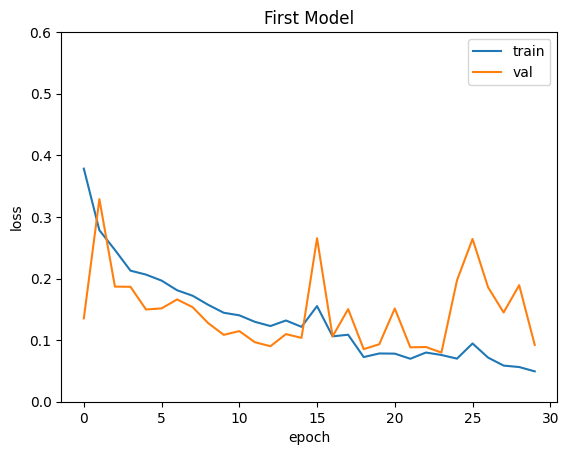

In [19]:
# loss for first model in train and validation set
import pandas as pd
loss_array = zip(train_loss_array1,val_loss_array1)
loss_df=pd.DataFrame(loss_array,columns=['train','val'])
loss_df.plot(title="First Model",ylim=(0,0.6),xlabel="epoch",ylabel="loss")
print('minimal val loss:' + str(np.min(val_loss_array1)))

maximum val acc:0.980225988700565


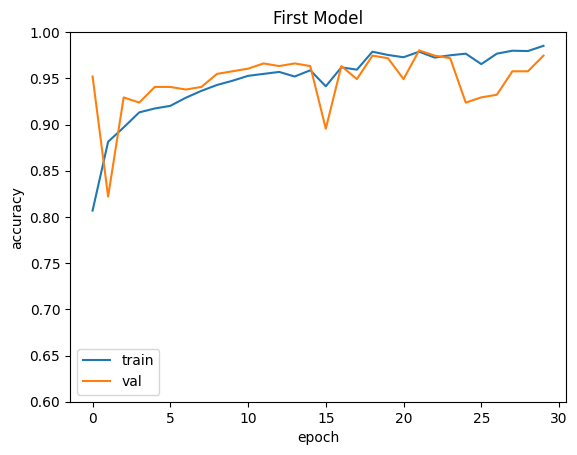

In [20]:
# accuracy for first model in train and validation set
acc_array = zip(train_correct_array1,val_correct_array1)
acc_df=pd.DataFrame(acc_array,columns=['train','val'])
acc_df.plot(title="First Model",ylim=(0.6,1),xlabel="epoch",ylabel="accuracy")
print('maximum val acc:' + str(np.max(val_correct_array1)))

# Training the second model

In [21]:
# Training for the second model
optimizer = optim.Adam(model_4.parameters(), lr=0.001)
# cross entropy loss function - softmax is computed as part of the loss!
criterion = nn.CrossEntropyLoss() 
# the number of epochs the model will train for. 
epochs = 30

In [22]:
# initialise : TOOK 2 MINUTES FOR TRAINING ON MY COMPUTER
train_loss_array=[]
val_loss_array=[]
train_correct_array=[]
val_correct_array=[]

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model_4, criterion, optimizer)
    val_loop(val_loader, model_4, criterion)
print("Done!")

Epoch 1
-------------------------------
Train_set: 
 Accuracy: 71.4%, Avg loss: 0.549040 

Val_set: 
 Accuracy: 90.7%, Avg loss: 0.240480 

Epoch 2
-------------------------------
Train_set: 
 Accuracy: 89.6%, Avg loss: 0.277764 

Val_set: 
 Accuracy: 93.5%, Avg loss: 0.185377 

Epoch 3
-------------------------------
Train_set: 
 Accuracy: 90.9%, Avg loss: 0.233930 

Val_set: 
 Accuracy: 94.4%, Avg loss: 0.167504 

Epoch 4
-------------------------------
Train_set: 
 Accuracy: 92.4%, Avg loss: 0.204256 

Val_set: 
 Accuracy: 94.6%, Avg loss: 0.133856 

Epoch 5
-------------------------------
Train_set: 
 Accuracy: 93.6%, Avg loss: 0.178193 

Val_set: 
 Accuracy: 96.3%, Avg loss: 0.119737 

Epoch 6
-------------------------------
Train_set: 
 Accuracy: 94.4%, Avg loss: 0.165385 

Val_set: 
 Accuracy: 96.9%, Avg loss: 0.108320 

Epoch 7
-------------------------------
Train_set: 
 Accuracy: 94.5%, Avg loss: 0.159724 

Val_set: 
 Accuracy: 96.9%, Avg loss: 0.103816 

Epoch 8
------------

minimal val loss:0.06565900912715329


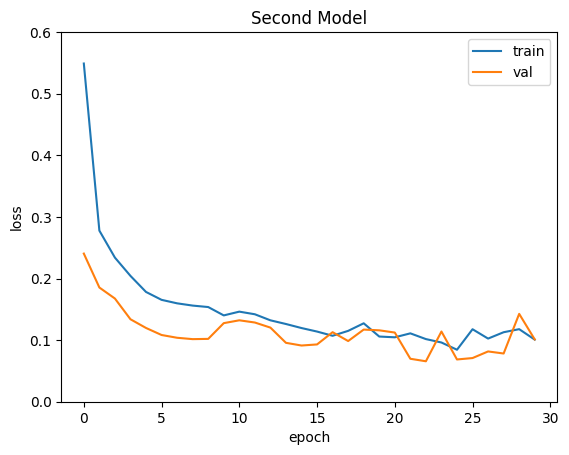

In [23]:
# loss for second model in train and validation set
loss_array = zip(train_loss_array,val_loss_array)
loss_df=pd.DataFrame(loss_array,columns=['train','val'])
loss_df.plot(title="Second Model",ylim=(0,0.6),xlabel="epoch",ylabel="loss")
print('minimal val loss:' + str(np.min(val_loss_array)))

maximum val acc:0.9774011299435028


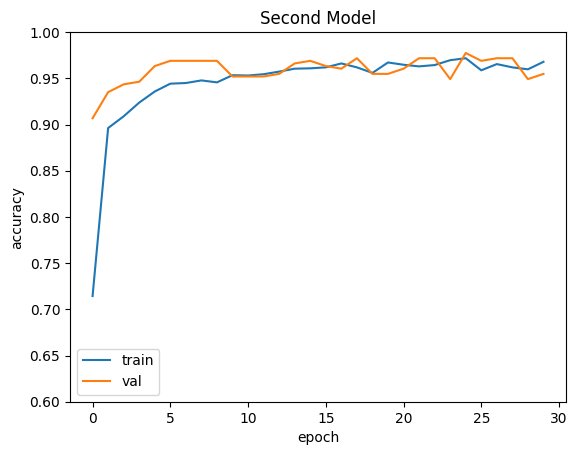

In [24]:
# accuracy for scond model in train and validation set
acc_array = zip(train_correct_array,val_correct_array)
acc_df=pd.DataFrame(acc_array,columns=['train','val'])
acc_df.plot(title="Second Model",ylim=(0.6,1),xlabel="epoch",ylabel="accuracy")
print('maximum val acc:' + str(np.max(val_correct_array)))

# Testing models on test set

In [25]:
# TEST MODELS ON TEST SET
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_2, y_pred_4 = torch.tensor([]),torch.tensor([])
y_obs_2, y_obs_4 =torch.tensor([]),torch.tensor([])



size = len(test_loader.dataset)
test_loss_2, test_correct_2 = 0, 0
test_loss_4, test_correct_4 = 0, 0
with torch.no_grad():
    for X, y in test_loader:
        pred_2 = model_2(X)
        y_pred_2 = torch.cat([y_pred_2,pred_2])
        y_obs_2 = torch.cat([y_obs_2,y])
        test_correct_2 += (pred_2.argmax(1) == y).type(torch.float).sum().item()

        pred_4 = model_4(X)
        y_pred_4 = torch.cat([y_pred_4,pred_4])
        y_obs_4 = torch.cat([y_obs_4,y])
        test_correct_4 += (pred_4.argmax(1) == y).type(torch.float).sum().item()

test_correct_2 = test_correct_2 /size
print("Accuracy on the test set for the first model: ",(100*test_correct_2)) # accuracy on test set for the first model
test_correct_4 = test_correct_4 /size
print("Accuracy on the test set for the second model: ",(100*test_correct_4)) # accuracy on test set for the second model

y_pred_2=y_pred_2.argmax(axis=1).detach().cpu().numpy()
y_obs_2=y_obs_2.numpy()

y_pred_4=y_pred_4.argmax(axis=1).detach().cpu().numpy()
y_obs_4=y_obs_4.numpy()

Accuracy on the test set for the first model:  96.61016949152543
Accuracy on the test set for the second model:  95.48022598870057


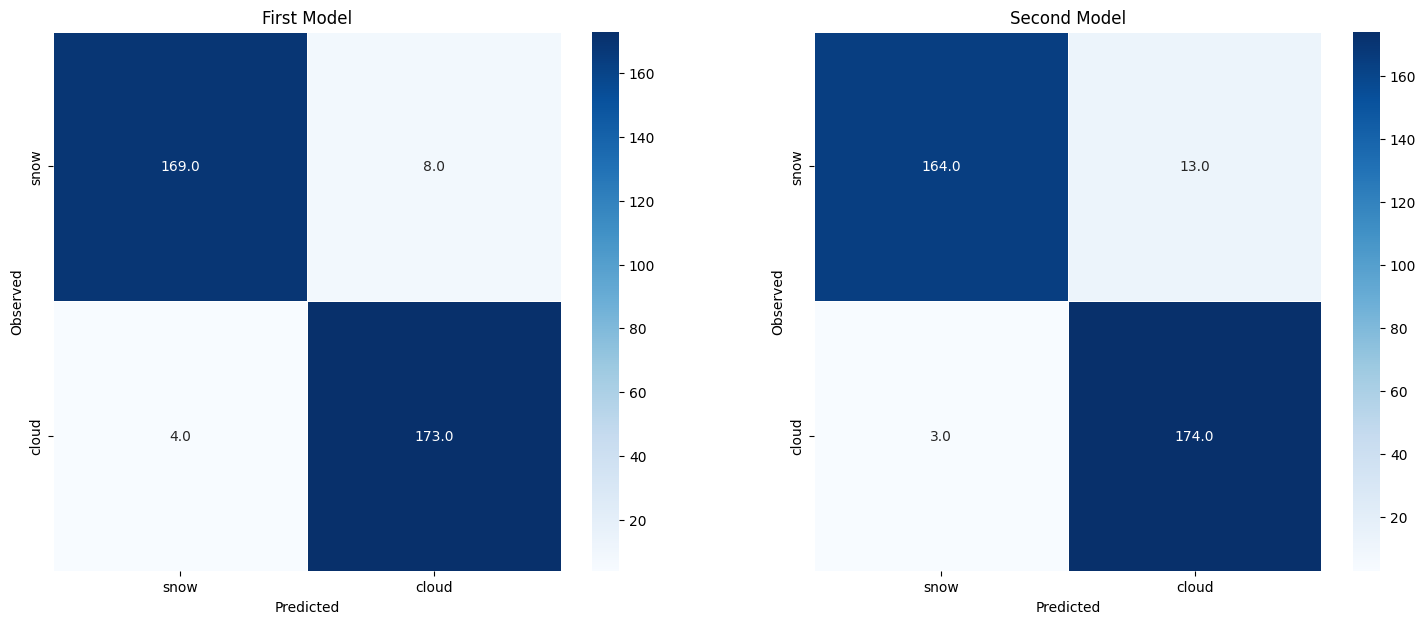

In [26]:
#make the plot
fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(18,7))


class_names = ('snow','cloud') # 0,1
df2=pd.DataFrame(confusion_matrix(y_obs_2, y_pred_2),index=class_names,columns=class_names) # ,index=class_names,columns=class_names
sns.heatmap(df2, annot=True,linewidths=.5, cmap="Blues", fmt=".1f", ax=ax[0])
df4=pd.DataFrame(confusion_matrix(y_obs_4, y_pred_4),index=class_names,columns=class_names) # ,index=class_names,columns=class_names
sns.heatmap(df4, annot=True,linewidths=.5, cmap="Blues", fmt=".1f", ax=ax[1])
ax[0].set_title('First Model')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Observed')
ax[1].set_title('Second Model')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Observed')
plt.show()

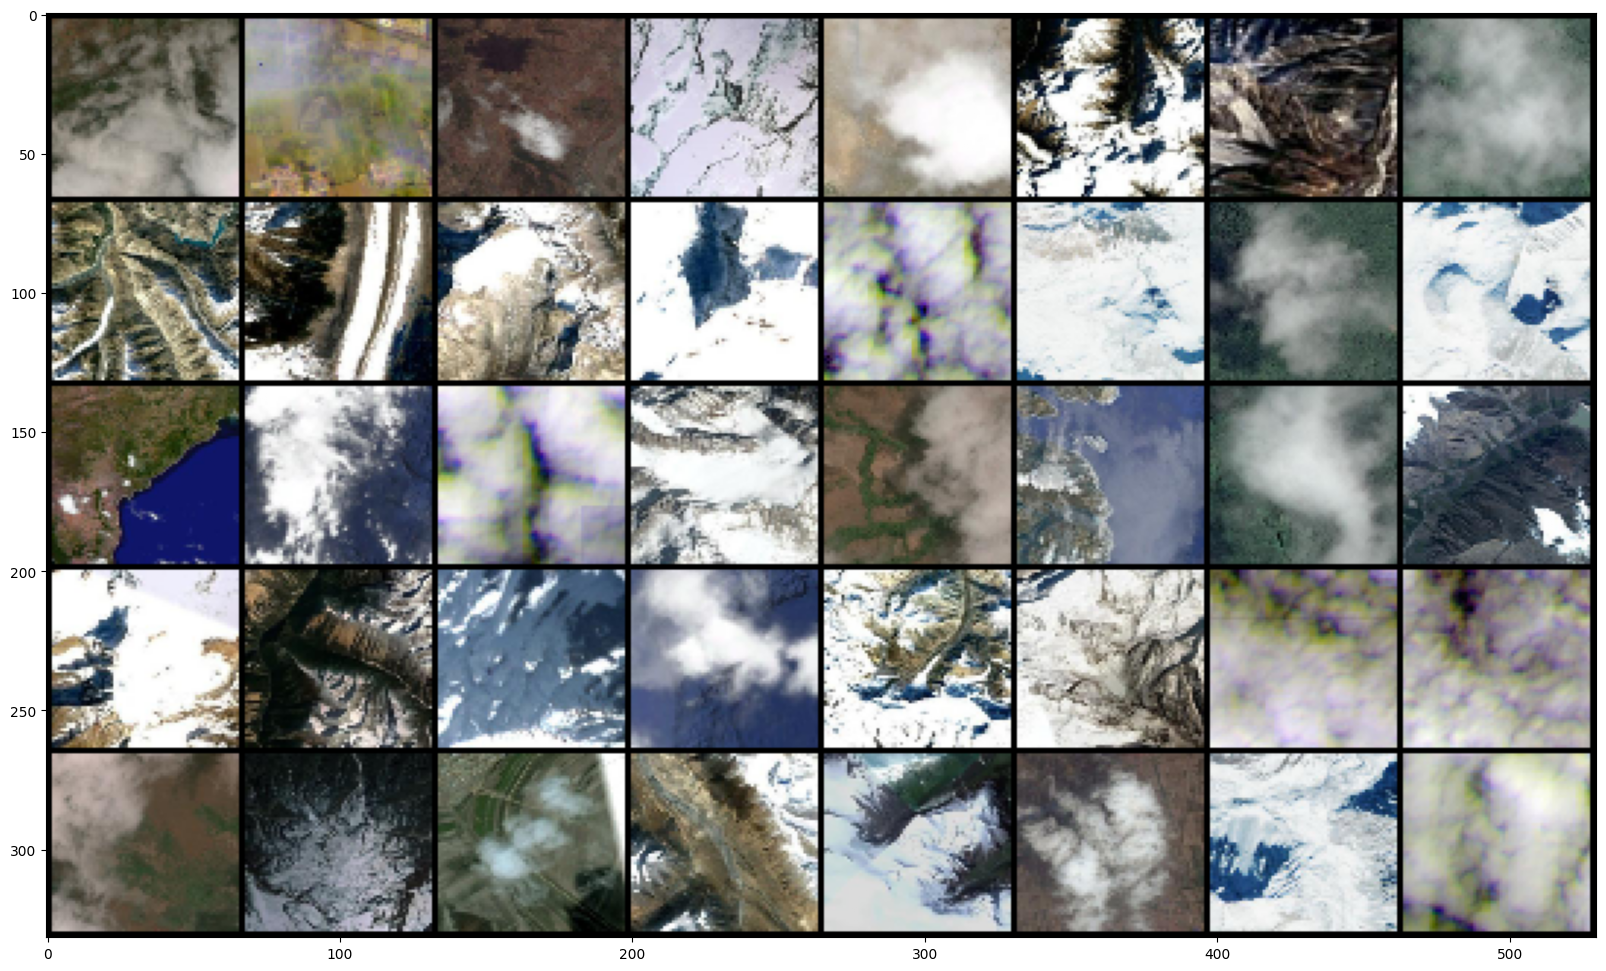

label:  cloud cloud cloud snow  cloud snow  snow  cloud snow  snow  snow  snow  cloud snow  cloud snow  cloud cloud cloud snow  cloud cloud cloud snow  snow  snow  snow  cloud snow  snow  cloud cloud cloud snow  cloud snow  snow  cloud snow  cloud
pred2:  cloud cloud cloud snow  cloud snow  snow  cloud snow  snow  snow  snow  cloud snow  cloud snow  cloud cloud cloud snow  cloud cloud cloud snow  snow  snow  snow  cloud snow  snow  cloud cloud cloud cloud cloud snow  snow  cloud snow  cloud
pred4:  cloud cloud cloud snow  cloud snow  snow  cloud snow  snow  snow  snow  cloud snow  cloud snow  cloud cloud cloud snow  cloud cloud cloud snow  snow  snow  snow  cloud snow  snow  cloud cloud cloud snow  cloud snow  cloud cloud snow  cloud


In [29]:
# We could lastly plot a sample of images and have their titles be a combination of their actual, and predicted class.

# get random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
pred_2 = model_2(images)
pred_4 = model_4(images)

# show images
npimg = torchvision.utils.make_grid(images).numpy()
plt.figure(figsize=(20,12))
plt.imshow(np.transpose(npimg, (1, 2, 0)),aspect='auto')
plt.show()

# print labels
y_obs = labels.numpy()
y_pred_2 = pred_2.argmax(axis=1).detach().cpu().numpy()
y_pred_4 = pred_4.argmax(axis=1).detach().cpu().numpy()
print("label: ",' '.join(f'{class_names[y_obs[j]]:5s}' for j in range(40)))
print("pred2: ",' '.join(f'{class_names[y_pred_2[j]]:5s}' for j in range(40)))
print("pred4: ",' '.join(f'{class_names[y_pred_4[j]]:5s}' for j in range(40)))